In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras import backend 
from PIL import Image
from keras.preprocessing import image
import scipy

In [3]:
train_dir = '/home/igor/workspace/CNN_emocao_humana-main/train/'
test_dir = '/home/igor/workspace/CNN_emocao_humana-main/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       disgust  surprise  angry  happy  neutral   sad  fear
train      436      3171   3995   7215     4965  4830  4097
      disgust  surprise  angry  happy  neutral   sad  fear
test      111       831    958   1774     1233  1247  1024


<Axes: >

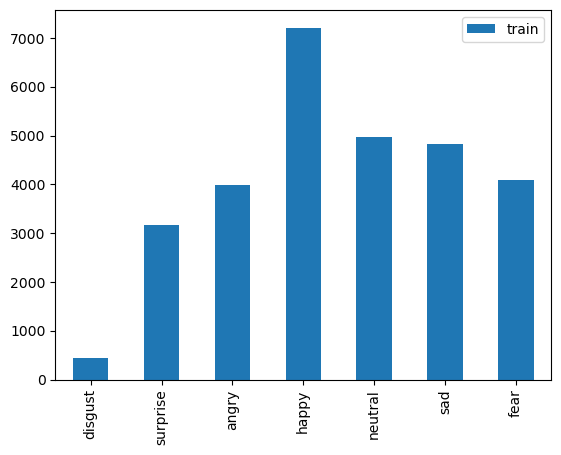

In [4]:
train_count.transpose().plot(kind='bar')

<Axes: >

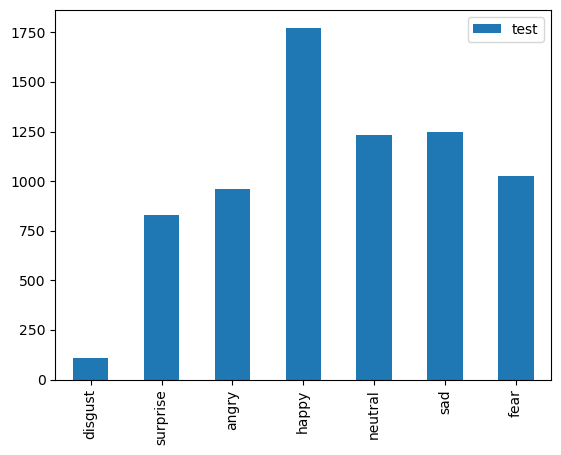

In [5]:
test_count.transpose().plot(kind='bar')

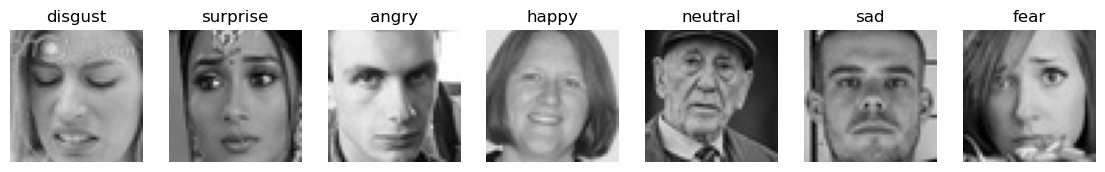

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.3,horizontal_flip=True)
training_set = train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(48,48),shuffle=True,color_mode='grayscale',class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,batch_size=32,target_size=(48,48),shuffle=True,color_mode='grayscale',class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [25]:
category_mapping = training_set.class_indices

Tentando usar uma GPU

In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


2024-04-24 13:23:21.595165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 13:23:21.638903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 13:23:21.639018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 13:23:21.642409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-24 13:23:21.642523: I tensorflow/compile

Definindo o modelo

In [10]:
def get_model(input_size, classes=7):
    model = tf.keras.models.Sequential()

    # Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
    # Add a batch normalization layer
    model.add(BatchNormalization())
    # Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # Add a second batch normalization layer
    model.add(BatchNormalization())
    # Add a max pooling layer with 2x2 pool size
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout layer with 0.25 dropout rate
    model.add(Dropout(0.25))

    # Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    # Add a third batch normalization layer
    model.add(BatchNormalization())
    # Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    # Add a fourth batch normalization layer
    model.add(BatchNormalization())
    # Add a max pooling layer with 2x2 pool size
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout layer with 0.25 dropout rate
    model.add(Dropout(0.25))

    # Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    # Add a fifth batch normalization layer
    model.add(BatchNormalization())
    # Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    # Add a sixth batch normalization layer
    model.add(BatchNormalization())
    # Add a max pooling layer with 2x2 pool size
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout layer with 0.25 dropout rate
    model.add(Dropout(0.25))

    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Add a dense layer with 256 neurons and relu activation function
    model.add(Dense(256, activation='relu'))
    # Add a seventh batch normalization layer
    model.add(BatchNormalization())
    # Add a dropout layer with 0.5 dropout rate
    model.add(Dropout(0.5))
    # Add a dense layer with 7 neurons (one for each class) and softmax activation function
    model.add(Dense(7, activation='softmax'))

    # Compile the model with categorical cross-entropy loss, adam optimizer, and accuracy metric
    model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

In [11]:
fernet = get_model((48, 48, 1), 7)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                        

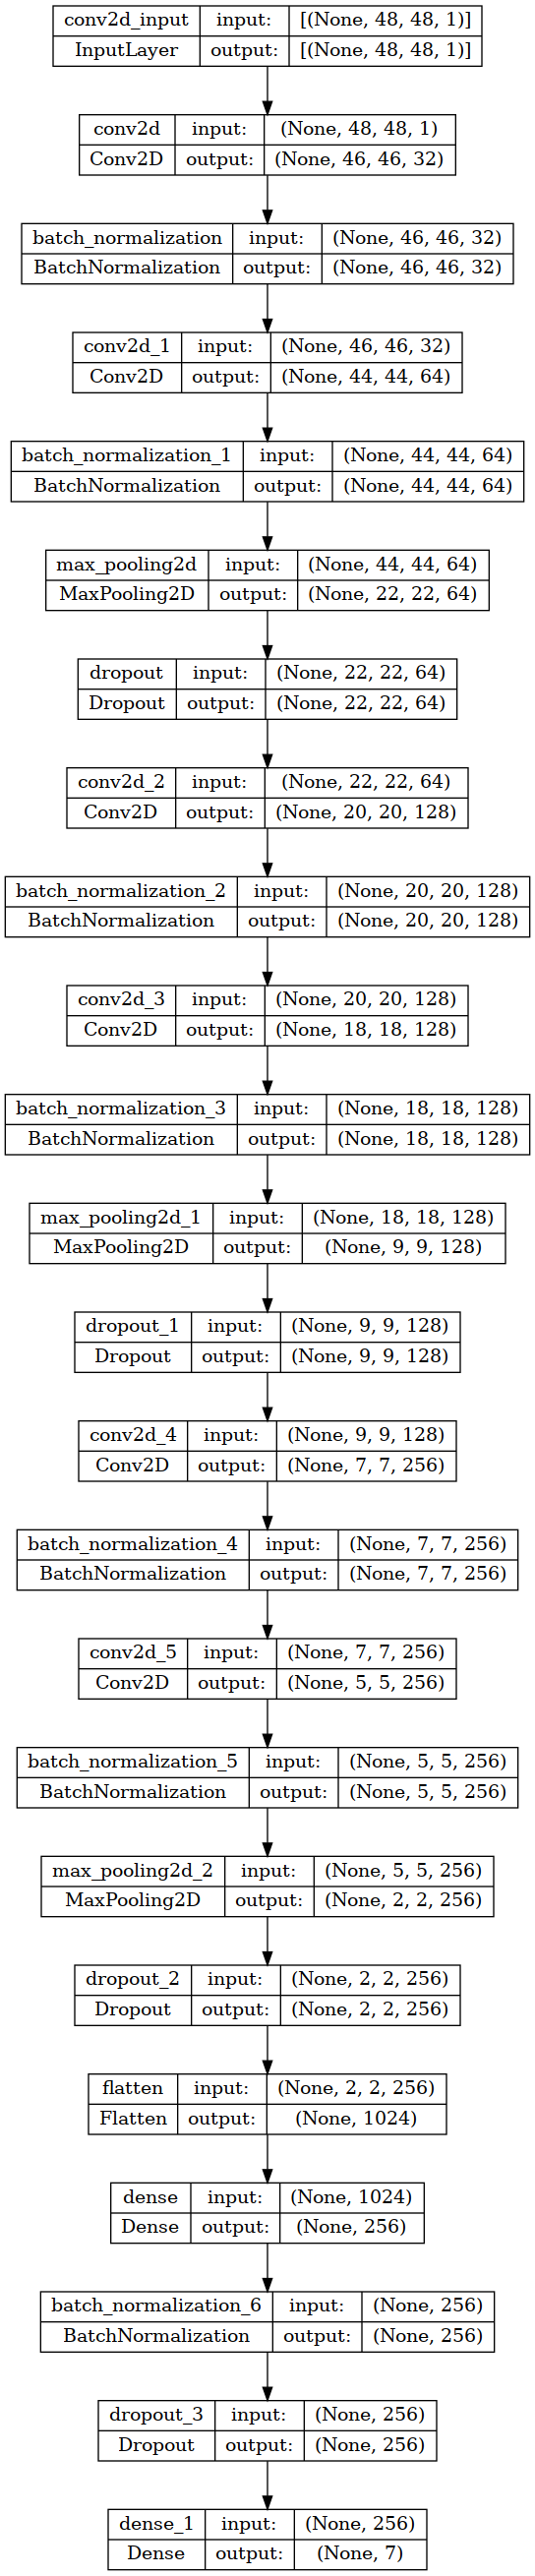

In [12]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [13]:
chk_path = 'model/ferNet.tf'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Callbacks
checkpoint = ModelCheckpoint(filepath=chk_path, save_best_only=True, verbose=1, mode='max', monitor='accuracy')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

# Incluindo todos os callbacks configurados, exceto EarlyStopping
callbacks = [checkpoint,tensorboard_callback, csv_logger]

In [14]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(
    x=training_set,
    validation_data=test_set,
    epochs=60,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
    
)

2024-04-24 13:23:22.944715: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/60


2024-04-24 13:23:25.435093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-24 13:23:25.784214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-04-24 13:23:25.944230: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 13:23:27.900928: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3bc8259aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 13:23:27.900978: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-04-24 13:23:27.907582: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer,

896/897 [============================>.] - ETA: 0s - loss: 2.6207 - accuracy: 0.2058
Epoch 1: accuracy improved from -inf to 0.20577, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 44s 40ms/step - loss: 2.6207 - accuracy: 0.2058 - val_loss: 1.7621 - val_accuracy: 0.3456
Epoch 2/60
896/897 [============================>.] - ETA: 0s - loss: 2.2038 - accuracy: 0.2614
Epoch 2: accuracy improved from 0.20577 to 0.26157, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 35s 39ms/step - loss: 2.2035 - accuracy: 0.2616 - val_loss: 1.6290 - val_accuracy: 0.3922
Epoch 3/60
897/897 [==============================] - ETA: 0s - loss: 1.9957 - accuracy: 0.3043
Epoch 3: accuracy improved from 0.26157 to 0.30425, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 34s 38ms/step - loss: 1.9957 - accuracy: 0.3043 - val_loss: 1.5679 - val_accuracy: 0.4015
Epoch 4/60
897/897 [==============================] - ETA: 0s - loss: 1.8581 - accuracy: 0.3317
Epoch 4: accuracy improved from 0.30425 to 0.33169, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 38s 42ms/step - loss: 1.8581 - accuracy: 0.3317 - val_loss: 1.5091 - val_accuracy: 0.4231
Epoch 5/60
896/897 [============================>.] - ETA: 0s - loss: 1.7449 - accuracy: 0.3587
Epoch 5: accuracy improved from 0.33169 to 0.35868, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 30s 34ms/step - loss: 1.7450 - accuracy: 0.3587 - val_loss: 1.4519 - val_accuracy: 0.4487
Epoch 6/60
897/897 [==============================] - ETA: 0s - loss: 1.6444 - accuracy: 0.3862
Epoch 6: accuracy improved from 0.35868 to 0.38620, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 33s 37ms/step - loss: 1.6444 - accuracy: 0.3862 - val_loss: 1.3687 - val_accuracy: 0.4743
Epoch 7/60
897/897 [==============================] - ETA: 0s - loss: 1.5659 - accuracy: 0.4101
Epoch 7: accuracy improved from 0.38620 to 0.41008, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 32s 35ms/step - loss: 1.5659 - accuracy: 0.4101 - val_loss: 1.3434 - val_accuracy: 0.4888
Epoch 8/60
896/897 [============================>.] - ETA: 0s - loss: 1.4997 - accuracy: 0.4344
Epoch 8: accuracy improved from 0.41008 to 0.43456, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 29s 33ms/step - loss: 1.4995 - accuracy: 0.4346 - val_loss: 1.2845 - val_accuracy: 0.5144
Epoch 9/60
896/897 [============================>.] - ETA: 0s - loss: 1.4328 - accuracy: 0.4554
Epoch 9: accuracy improved from 0.43456 to 0.45535, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 34ms/step - loss: 1.4332 - accuracy: 0.4553 - val_loss: 1.2478 - val_accuracy: 0.5234
Epoch 10/60
897/897 [==============================] - ETA: 0s - loss: 1.3853 - accuracy: 0.4720
Epoch 10: accuracy improved from 0.45535 to 0.47198, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 30s 33ms/step - loss: 1.3853 - accuracy: 0.4720 - val_loss: 1.2109 - val_accuracy: 0.5353
Epoch 11/60
897/897 [==============================] - ETA: 0s - loss: 1.3403 - accuracy: 0.4892
Epoch 11: accuracy improved from 0.47198 to 0.48921, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 40s 45ms/step - loss: 1.3403 - accuracy: 0.4892 - val_loss: 1.2130 - val_accuracy: 0.5409
Epoch 12/60
897/897 [==============================] - ETA: 0s - loss: 1.3148 - accuracy: 0.5019
Epoch 12: accuracy improved from 0.48921 to 0.50194, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 34s 38ms/step - loss: 1.3148 - accuracy: 0.5019 - val_loss: 1.1811 - val_accuracy: 0.5532
Epoch 13/60
896/897 [============================>.] - ETA: 0s - loss: 1.2804 - accuracy: 0.5147
Epoch 13: accuracy improved from 0.50194 to 0.51480, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 32s 35ms/step - loss: 1.2804 - accuracy: 0.5148 - val_loss: 1.1889 - val_accuracy: 0.5481
Epoch 14/60
896/897 [============================>.] - ETA: 0s - loss: 1.2597 - accuracy: 0.5243
Epoch 14: accuracy improved from 0.51480 to 0.52436, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 34ms/step - loss: 1.2596 - accuracy: 0.5244 - val_loss: 1.1291 - val_accuracy: 0.5739
Epoch 15/60
896/897 [============================>.] - ETA: 0s - loss: 1.2362 - accuracy: 0.5305
Epoch 15: accuracy improved from 0.52436 to 0.53049, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 36s 40ms/step - loss: 1.2361 - accuracy: 0.5305 - val_loss: 1.1251 - val_accuracy: 0.5771
Epoch 16/60
897/897 [==============================] - ETA: 0s - loss: 1.2201 - accuracy: 0.5414
Epoch 16: accuracy improved from 0.53049 to 0.54137, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 35s 38ms/step - loss: 1.2201 - accuracy: 0.5414 - val_loss: 1.0979 - val_accuracy: 0.5830
Epoch 17/60
897/897 [==============================] - ETA: 0s - loss: 1.1976 - accuracy: 0.5521
Epoch 17: accuracy improved from 0.54137 to 0.55208, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 39s 44ms/step - loss: 1.1976 - accuracy: 0.5521 - val_loss: 1.1073 - val_accuracy: 0.5850
Epoch 18/60
897/897 [==============================] - ETA: 0s - loss: 1.1795 - accuracy: 0.5556
Epoch 18: accuracy improved from 0.55208 to 0.55557, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 34s 38ms/step - loss: 1.1795 - accuracy: 0.5556 - val_loss: 1.1271 - val_accuracy: 0.5791
Epoch 19/60
896/897 [============================>.] - ETA: 0s - loss: 1.1648 - accuracy: 0.5631
Epoch 19: accuracy improved from 0.55557 to 0.56289, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 34s 38ms/step - loss: 1.1651 - accuracy: 0.5629 - val_loss: 1.0773 - val_accuracy: 0.5911
Epoch 20/60
897/897 [==============================] - ETA: 0s - loss: 1.1511 - accuracy: 0.5683
Epoch 20: accuracy improved from 0.56289 to 0.56826, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 36s 40ms/step - loss: 1.1511 - accuracy: 0.5683 - val_loss: 1.1102 - val_accuracy: 0.5840
Epoch 21/60
896/897 [============================>.] - ETA: 0s - loss: 1.1350 - accuracy: 0.5740
Epoch 21: accuracy improved from 0.56826 to 0.57401, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 34s 38ms/step - loss: 1.1351 - accuracy: 0.5740 - val_loss: 1.0785 - val_accuracy: 0.5957
Epoch 22/60
896/897 [============================>.] - ETA: 0s - loss: 1.1274 - accuracy: 0.5779
Epoch 22: accuracy improved from 0.57401 to 0.57809, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 35s 39ms/step - loss: 1.1269 - accuracy: 0.5781 - val_loss: 1.1045 - val_accuracy: 0.5873
Epoch 23/60
896/897 [============================>.] - ETA: 0s - loss: 1.1151 - accuracy: 0.5823
Epoch 23: accuracy improved from 0.57809 to 0.58242, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 36s 40ms/step - loss: 1.1148 - accuracy: 0.5824 - val_loss: 1.0550 - val_accuracy: 0.6062
Epoch 24/60
897/897 [==============================] - ETA: 0s - loss: 1.1075 - accuracy: 0.5865
Epoch 24: accuracy improved from 0.58242 to 0.58650, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 34s 38ms/step - loss: 1.1075 - accuracy: 0.5865 - val_loss: 1.0505 - val_accuracy: 0.6044
Epoch 25/60
896/897 [============================>.] - ETA: 0s - loss: 1.0896 - accuracy: 0.5949
Epoch 25: accuracy improved from 0.58650 to 0.59480, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 36s 40ms/step - loss: 1.0897 - accuracy: 0.5948 - val_loss: 1.0485 - val_accuracy: 0.6080
Epoch 26/60
896/897 [============================>.] - ETA: 0s - loss: 1.0770 - accuracy: 0.5955
Epoch 26: accuracy improved from 0.59480 to 0.59556, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 34s 38ms/step - loss: 1.0767 - accuracy: 0.5956 - val_loss: 1.0626 - val_accuracy: 0.6016
Epoch 27/60
896/897 [============================>.] - ETA: 0s - loss: 1.0713 - accuracy: 0.6014
Epoch 27: accuracy improved from 0.59556 to 0.60149, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 34ms/step - loss: 1.0715 - accuracy: 0.6015 - val_loss: 1.0155 - val_accuracy: 0.6230
Epoch 28/60
896/897 [============================>.] - ETA: 0s - loss: 1.0676 - accuracy: 0.6025
Epoch 28: accuracy improved from 0.60149 to 0.60247, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 32s 36ms/step - loss: 1.0677 - accuracy: 0.6025 - val_loss: 1.0470 - val_accuracy: 0.6049
Epoch 29/60
896/897 [============================>.] - ETA: 0s - loss: 1.0532 - accuracy: 0.6081
Epoch 29: accuracy improved from 0.60247 to 0.60808, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 35s 39ms/step - loss: 1.0533 - accuracy: 0.6081 - val_loss: 1.0269 - val_accuracy: 0.6211
Epoch 30/60
897/897 [==============================] - ETA: 0s - loss: 1.0450 - accuracy: 0.6086
Epoch 30: accuracy improved from 0.60808 to 0.60864, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 32s 36ms/step - loss: 1.0450 - accuracy: 0.6086 - val_loss: 1.0301 - val_accuracy: 0.6151
Epoch 31/60
897/897 [==============================] - ETA: 0s - loss: 1.0321 - accuracy: 0.6141
Epoch 31: accuracy improved from 0.60864 to 0.61408, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 40s 44ms/step - loss: 1.0321 - accuracy: 0.6141 - val_loss: 1.0210 - val_accuracy: 0.6274
Epoch 32/60
897/897 [==============================] - ETA: 0s - loss: 1.0246 - accuracy: 0.6150
Epoch 32: accuracy improved from 0.61408 to 0.61502, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 35s 38ms/step - loss: 1.0246 - accuracy: 0.6150 - val_loss: 1.0041 - val_accuracy: 0.6233
Epoch 33/60
896/897 [============================>.] - ETA: 0s - loss: 1.0184 - accuracy: 0.6194
Epoch 33: accuracy improved from 0.61502 to 0.61935, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 36s 40ms/step - loss: 1.0184 - accuracy: 0.6193 - val_loss: 0.9960 - val_accuracy: 0.6272
Epoch 34/60
896/897 [============================>.] - ETA: 0s - loss: 1.0069 - accuracy: 0.6189
Epoch 34: accuracy did not improve from 0.61935
897/897 [==============================] - 28s 31ms/step - loss: 1.0071 - accuracy: 0.6188 - val_loss: 1.0399 - val_accuracy: 0.6151
Epoch 35/60
897/897 [==============================] - ETA: 0s - loss: 1.0053 - accuracy: 0.6246
Epoch 35: accuracy improved from 0.61935 to 0.62461, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 35ms/step - loss: 1.0053 - accuracy: 0.6246 - val_loss: 1.0080 - val_accuracy: 0.6295
Epoch 36/60
897/897 [==============================] - ETA: 0s - loss: 0.9988 - accuracy: 0.6259
Epoch 36: accuracy improved from 0.62461 to 0.62594, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 35ms/step - loss: 0.9988 - accuracy: 0.6259 - val_loss: 1.0086 - val_accuracy: 0.6249
Epoch 37/60
896/897 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.6335
Epoch 37: accuracy improved from 0.62594 to 0.63361, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 34ms/step - loss: 0.9872 - accuracy: 0.6336 - val_loss: 0.9804 - val_accuracy: 0.6367
Epoch 38/60
896/897 [============================>.] - ETA: 0s - loss: 0.9734 - accuracy: 0.6380
Epoch 38: accuracy improved from 0.63361 to 0.63797, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 36s 40ms/step - loss: 0.9732 - accuracy: 0.6380 - val_loss: 0.9888 - val_accuracy: 0.6373
Epoch 39/60
897/897 [==============================] - ETA: 0s - loss: 0.9643 - accuracy: 0.6407
Epoch 39: accuracy improved from 0.63797 to 0.64072, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 36s 40ms/step - loss: 0.9643 - accuracy: 0.6407 - val_loss: 0.9870 - val_accuracy: 0.6366
Epoch 40/60
897/897 [==============================] - ETA: 0s - loss: 0.9630 - accuracy: 0.6389
Epoch 40: accuracy did not improve from 0.64072
897/897 [==============================] - 34s 37ms/step - loss: 0.9630 - accuracy: 0.6389 - val_loss: 0.9943 - val_accuracy: 0.6360
Epoch 41/60
896/897 [============================>.] - ETA: 0s - loss: 0.9538 - accuracy: 0.6471
Epoch 41: accuracy improved from 0.64072 to 0.64717, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 34s 38ms/step - loss: 0.9537 - accuracy: 0.6472 - val_loss: 0.9730 - val_accuracy: 0.6433
Epoch 42/60
896/897 [============================>.] - ETA: 0s - loss: 0.9492 - accuracy: 0.6468
Epoch 42: accuracy did not improve from 0.64717
897/897 [==============================] - 33s 37ms/step - loss: 0.9495 - accuracy: 0.6466 - val_loss: 0.9746 - val_accuracy: 0.6371
Epoch 43/60
896/897 [============================>.] - ETA: 0s - loss: 0.9452 - accuracy: 0.6476
Epoch 43: accuracy improved from 0.64717 to 0.64763, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 32s 36ms/step - loss: 0.9451 - accuracy: 0.6476 - val_loss: 0.9859 - val_accuracy: 0.6378
Epoch 44/60
896/897 [============================>.] - ETA: 0s - loss: 0.9336 - accuracy: 0.6510
Epoch 44: accuracy improved from 0.64763 to 0.65118, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 32s 36ms/step - loss: 0.9333 - accuracy: 0.6512 - val_loss: 1.0005 - val_accuracy: 0.6307
Epoch 45/60
897/897 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.6555
Epoch 45: accuracy improved from 0.65118 to 0.65554, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 35ms/step - loss: 0.9292 - accuracy: 0.6555 - val_loss: 0.9659 - val_accuracy: 0.6430
Epoch 46/60
896/897 [============================>.] - ETA: 0s - loss: 0.9229 - accuracy: 0.6580
Epoch 46: accuracy improved from 0.65554 to 0.65812, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 37s 41ms/step - loss: 0.9226 - accuracy: 0.6581 - val_loss: 0.9715 - val_accuracy: 0.6409
Epoch 47/60
897/897 [==============================] - ETA: 0s - loss: 0.9149 - accuracy: 0.6592
Epoch 47: accuracy improved from 0.65812 to 0.65920, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 38s 42ms/step - loss: 0.9149 - accuracy: 0.6592 - val_loss: 0.9909 - val_accuracy: 0.6402
Epoch 48/60
896/897 [============================>.] - ETA: 0s - loss: 0.9161 - accuracy: 0.6590
Epoch 48: accuracy did not improve from 0.65920
897/897 [==============================] - 33s 37ms/step - loss: 0.9164 - accuracy: 0.6590 - val_loss: 1.0236 - val_accuracy: 0.6230
Epoch 49/60
896/897 [============================>.] - ETA: 0s - loss: 0.9032 - accuracy: 0.6641
Epoch 49: accuracy improved from 0.65920 to 0.66416, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 30s 34ms/step - loss: 0.9032 - accuracy: 0.6642 - val_loss: 0.9775 - val_accuracy: 0.6437
Epoch 50/60
897/897 [==============================] - ETA: 0s - loss: 0.8950 - accuracy: 0.6689
Epoch 50: accuracy improved from 0.66416 to 0.66886, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 35s 39ms/step - loss: 0.8950 - accuracy: 0.6689 - val_loss: 0.9882 - val_accuracy: 0.6399
Epoch 51/60
896/897 [============================>.] - ETA: 0s - loss: 0.8938 - accuracy: 0.6694
Epoch 51: accuracy improved from 0.66886 to 0.66939, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 35s 39ms/step - loss: 0.8937 - accuracy: 0.6694 - val_loss: 0.9804 - val_accuracy: 0.6427
Epoch 52/60
896/897 [============================>.] - ETA: 0s - loss: 0.8862 - accuracy: 0.6716
Epoch 52: accuracy improved from 0.66939 to 0.67165, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 32s 35ms/step - loss: 0.8861 - accuracy: 0.6717 - val_loss: 0.9681 - val_accuracy: 0.6484
Epoch 53/60
897/897 [==============================] - ETA: 0s - loss: 0.8821 - accuracy: 0.6701
Epoch 53: accuracy did not improve from 0.67165
897/897 [==============================] - 30s 33ms/step - loss: 0.8821 - accuracy: 0.6701 - val_loss: 0.9666 - val_accuracy: 0.6454
Epoch 54/60
896/897 [============================>.] - ETA: 0s - loss: 0.8724 - accuracy: 0.6756
Epoch 54: accuracy improved from 0.67165 to 0.67559, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 36s 40ms/step - loss: 0.8724 - accuracy: 0.6756 - val_loss: 0.9691 - val_accuracy: 0.6461
Epoch 55/60
897/897 [==============================] - ETA: 0s - loss: 0.8732 - accuracy: 0.6789
Epoch 55: accuracy improved from 0.67559 to 0.67891, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 35s 39ms/step - loss: 0.8732 - accuracy: 0.6789 - val_loss: 0.9774 - val_accuracy: 0.6468
Epoch 56/60
897/897 [==============================] - ETA: 0s - loss: 0.8630 - accuracy: 0.6787
Epoch 56: accuracy did not improve from 0.67891
897/897 [==============================] - 29s 33ms/step - loss: 0.8630 - accuracy: 0.6787 - val_loss: 0.9691 - val_accuracy: 0.6484
Epoch 57/60
897/897 [==============================] - ETA: 0s - loss: 0.8599 - accuracy: 0.6800
Epoch 57: accuracy improved from 0.67891 to 0.67995, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 35ms/step - loss: 0.8599 - accuracy: 0.6800 - val_loss: 0.9684 - val_accuracy: 0.6532
Epoch 58/60
897/897 [==============================] - ETA: 0s - loss: 0.8477 - accuracy: 0.6863
Epoch 58: accuracy improved from 0.67995 to 0.68626, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 35ms/step - loss: 0.8477 - accuracy: 0.6863 - val_loss: 0.9749 - val_accuracy: 0.6468
Epoch 59/60
896/897 [============================>.] - ETA: 0s - loss: 0.8448 - accuracy: 0.6841
Epoch 59: accuracy did not improve from 0.68626
897/897 [==============================] - 29s 32ms/step - loss: 0.8446 - accuracy: 0.6842 - val_loss: 0.9895 - val_accuracy: 0.6454
Epoch 60/60
896/897 [============================>.] - ETA: 0s - loss: 0.8484 - accuracy: 0.6872
Epoch 60: accuracy improved from 0.68626 to 0.68707, saving model to model/ferNet.tf
INFO:tensorflow:Assets written to: model/ferNet.tf/assets


INFO:tensorflow:Assets written to: model/ferNet.tf/assets


897/897 [==============================] - 31s 35ms/step - loss: 0.8483 - accuracy: 0.6871 - val_loss: 0.9590 - val_accuracy: 0.6554


In [26]:
import pickle

# Example dictionary
my_dict = {'a': 1, 'b': 2, 'c': 3}

# Define the file path
file_path = 'category_map.pkl'

# Write the dictionary to a file using pickle
with open(file_path, 'wb') as f:
    pickle.dump(category_mapping, f)

print("Dictionary exported to", file_path)

Dictionary exported to category_map.pkl


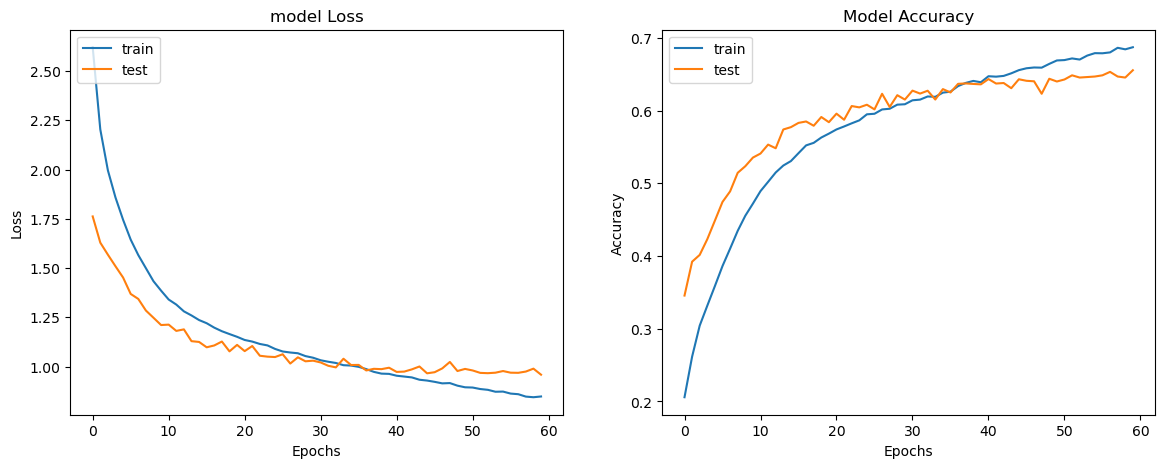

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [16]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))
fernet.save_weights('fernet_bestweight.weights.h5')

225/225 [==============================] - 3s 12ms/step - loss: 0.9582 - accuracy: 0.6558
final train accuracy = 75.61 , validation accuracy = 65.58


898/898 [==============================] - 17s 19ms/step
Confusion Matrix
[[ 564   47  412 1030  781  694  467]
 [  54    6   46  119   85   72   54]
 [ 574   67  414 1108  818  659  457]
 [ 998  122  750 1900 1377 1249  819]
 [ 671   66  494 1356  942  873  563]
 [ 676   77  487 1225  974  832  559]
 [ 447   46  296  814  648  540  380]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.10      0.12      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.19      0.18      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.12      0.12      0.12      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



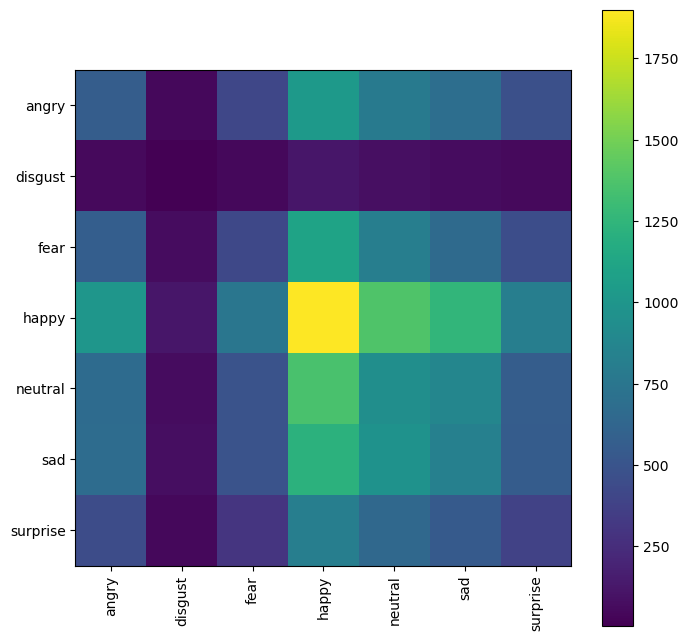

In [27]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)
plt.savefig('confusion_matrix.png')

Checando se a camera foi detectada:

In [21]:
import cv2

def list_available_cameras():
    num_cameras = 10
    available_cameras = []
    for i in range(num_cameras):
        cap = cv2.VideoCapture(i, cv2.CAP_DSHOW)
        if not cap.isOpened():
            break
        else:
            available_cameras.append(i)
        cap.release()
    return available_cameras

print("Índices das câmeras disponíveis:", list_available_cameras())

Índices das câmeras disponíveis: []


In [30]:
import cv2
import numpy as np
import tensorflow
import warnings 
warnings.filterwarnings('ignore')
import pickle
# Define the file path
file_path = 'category_map.pkl'

# Read the dictionary from the file using pickle
with open(file_path, 'rb') as f:
    my_dict = pickle.load(f)

print("Dictionary imported successfully:", my_dict)
model=tensorflow.keras.models.load_model("ferNet.keras")
cap=cv2.VideoCapture(0)
while(True):
    ret,frame=cap.read()
    facecascade=cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=facecascade.detectMultiScale(gray)
    for x,y,w,h in faces:
        roi_gray=gray[y:y+h,x:x+w]
        roi_color=frame[y:y+h,x:x+w]
        roi_color_resized=cv2.resize(roi_color,(224,224))
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),3)
        final_img=np.expand_dims(roi_color_resized,axis=0)
        final_img=final_img/255.0
        index=np.argmax((model.predict(final_img)))
        cv2.putText( img = frame,text = my_dict[index],org = (x-20,y-20),fontFace = cv2.FONT_HERSHEY_DUPLEX,
                    fontScale = 1.0,color = (125, 246, 55),thickness = 3)
    cv2.imshow("window",frame)
    # cv2.imshow("window2",roi_color_resized)
    if cv2.waitKey(2) & 0xFF==ord("q"):
        break
cap.release()
cv2.destroyAllWindows()


Dictionary imported successfully: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 48, 48, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [19]:
# import cv2
# import numpy as np
# from tensorflow.keras.models import load_model
# from keras.preprocessing import image
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# # Carregar modelo treinado de emoções
# model = load_model('model/ferNet.tf')

# # Inicializar a captura de vídeo da webcam
# cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)


# # Definir rótulos das emoções
# emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# while True:
#     # Capturar frame da webcam
#     ret, frame = cap.read()
#     if not ret:
#         break
    
#     # Pré-processamento da imagem
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#     faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
#     for (x, y, w, h) in faces:
#         face_roi = gray[y:y+h, x:x+w]
#         resized = cv2.resize(face_roi, (48, 48))
#         img = image.img_to_array(resized)
#         img = np.expand_dims(img, axis=0)
#         img = preprocess_input(img)
        
#         # Prever emoção
#         predictions = model.predict(img)
#         label = np.argmax(predictions)
#         emotion = emotion_labels[label]
        
#         # Desenhar retângulo e texto na imagem
#         cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
#         cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
#     # Exibir frame com emoção detectada
#     cv2.imshow('Emotion Detection', frame)
    
#     # Parar loop quando 'q' for pressionado
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Liberar recursos e fechar janela
# cap.release()
# cv2.destroyAllWindows()
